# Steps
1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [1053]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houses_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

houses_df.head(3)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500


In [1054]:
# Replace missing numerical values with the mean and missing categoricals ('None') with 'No--' 
# -- = first to letters of feature, ie. NoFe = 'no fence' 
# and the lone missing electrical value with house_df.electrical.mode()

houses_df['electrical'].fillna(str(houses_df['electrical'].mode()), inplace=True)

for column_name in houses_df.columns[3:]:
    for idx, value in enumerate(houses_df[column_name]):
        if pd.isna(value):
            try:
                houses_df[column_name].fillna(houses_df[column_name].mean(), inplace=True)
            except:
                houses_df[column_name].fillna('No' + column_name[:2].capitalize(), inplace=True)

In [1055]:
# Creating a list of non-numeric features
non_numeric_columns = houses_df.select_dtypes(['object']).columns
print(sorted(non_numeric_columns))
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

['alley', 'bldgtype', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'bsmtqual', 'centralair', 'condition1', 'condition2', 'electrical', 'extercond', 'exterior1st', 'exterior2nd', 'exterqual', 'fence', 'fireplacequ', 'foundation', 'functional', 'garagecond', 'garagefinish', 'garagequal', 'garagetype', 'heating', 'heatingqc', 'housestyle', 'kitchenqual', 'landcontour', 'landslope', 'lotconfig', 'lotshape', 'masvnrtype', 'miscfeature', 'mszoning', 'neighborhood', 'paveddrive', 'poolqc', 'roofmatl', 'roofstyle', 'salecondition', 'saletype', 'street', 'utilities']
The number of non-numerical columns is 43


In [1056]:
# Creating a list of numeric features
numeric_columns = houses_df.select_dtypes(['int64','float64']).columns
print(sorted(numeric_columns))
print("The number of non-numerical columns is {}".format(len(numeric_columns)))

['bedroomabvgr', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtfullbath', 'bsmthalfbath', 'bsmtunfsf', 'enclosedporch', 'fireplaces', 'firstflrsf', 'fullbath', 'garagearea', 'garagecars', 'garageyrblt', 'grlivarea', 'halfbath', 'id', 'kitchenabvgr', 'lotarea', 'lotfrontage', 'lowqualfinsf', 'masvnrarea', 'miscval', 'mosold', 'mssubclass', 'openporchsf', 'overallcond', 'overallqual', 'poolarea', 'saleprice', 'screenporch', 'secondflrsf', 'threessnporch', 'totalbsmtsf', 'totrmsabvgrd', 'wooddecksf', 'yearbuilt', 'yearremodadd', 'yrsold']
The number of non-numerical columns is 38


In [1057]:
# Creating our dummy variable
columns = ['poolqc']

# Create a dataframe with added dummy features
houses_df_dummies = pd.get_dummies(houses_df, columns=columns, drop_first=True)
dummy_columns = [c for c in houses_df_dummies.columns if any([c.startswith(n) for n in columns])]
dummy_columns

['poolqc_Fa', 'poolqc_Gd', 'poolqc_NoPo']

In [1058]:
# Using the features of our most successful OLS model so far (adjusted R-squared of 0.738) with added
# 'overallqual','overallcond', and removing features with little statistical significance ('alley_Pave',
# 'garagetype_Attchd','garagetype_BuiltIn','garagetype_NoGa','poolqc_NoPo') and 'poolarea'
features = ['poolqc_Fa','poolqc_Gd','grlivarea', 'lotarea','totalbsmtsf','garagearea', 'bedroomabvgr',
            'yearbuilt','fullbath', 'kitchenabvgr','totrmsabvgrd','fireplaces','overallqual','overallcond',
            'lotfrontage']

X = houses_df_dummies[features]
Y = houses_df_dummies.saleprice

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

# Don't forget to add a constant for statsmodels OLS
X_train_c = sm.add_constant(X_train)

# Let's train our new model
results = sm.OLS(y_train, X_train_c).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     339.2
Date:                Mon, 03 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:40:51   Log-Likelihood:                -13872.
No. Observations:                1168   AIC:                         2.777e+04
Df Residuals:                    1153   BIC:                         2.785e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.009e+06   1.03e+05     -9.750      0.000   -1.21e+06   -8.06e+05
poolqc_Fa      2.27e-06   1.92e-07     11.812      0.000    1.89e-06    2.65e-06
poolqc_Gd    -2.663e+05   2.63e+04    -10.125      0.000   -3.18e+05   -2.15e+05
grlivarea       43.1143      4.586      9.402      0.000      34.117      52.112
lotarea          0.5381      0.105      5.114      0.000       0.332       0.744
totalbsmtsf     26.4878      3.061      8.652      0.000      20.481      32.494
garagearea      41.3140      6.388      6.468      0.000      28.781      53.847
bedroomabvgr -9225.2116   1836.065     -5.024      0.000   -1.28e+04   -5622.808
yearbuilt      468.4430     52.662      8.895      0.000     365.120     571.766
fullbath        61.1018   2846.432      0.021      0.983   -5523.666    5645.869
kitchenabvgr   -1.7e+04   5258.655     -3.234      0.001   -2.73e+04   -6687.281
totrmsabvgrd  6273.1059   1381.433      4.541      0.000    3562.702    8983.510
fireplaces    7483.7038   1883.237      3.974      0.000    3788.748    1.12e+04
overallqual   1.763e+04   1303.825     13.518      0.000    1.51e+04    2.02e+04
overallcond   6622.5313   1030.114      6.429      0.000    4601.424    8643.639
lotfrontage     25.9766     52.841      0.492      0.623     -77.698     129.651
==============================================================================
Omnibus:                      379.375   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21736.517
Skew:                           0.656   Prob(JB):                         0.00
Kurtosis:                      24.093   Cond. No.                     5.70e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.36e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

> ### The previous summary shows how well our model performs on the training data, but we will resort to several different scikit learn regression models to assess its performance on the testing data.

In [1059]:
# sklearn's OLS
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_train - y_preds_train) / y_train)) * 100))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.804614937568295
Mean absolute percentage error of the prediction is: 13.194506493626479
-----Test set statistics-----
R-squared of the model in test set is: 0.7558639942881631
Mean absolute error of the prediction is: 23612.741966202557
Mean squared error of the prediction is: 1639056897.3962512
Root mean squared error of the prediction is: 40485.267658695935
Mean absolute percentage error of the prediction is: 14.060866695200334


> ### We can see that the model is not performing as well on the testing data. Below we'll take a look at error plots and distributions as well as target distributions. We'll then adopt some strategies, including feature engineering, to deal with what we find.

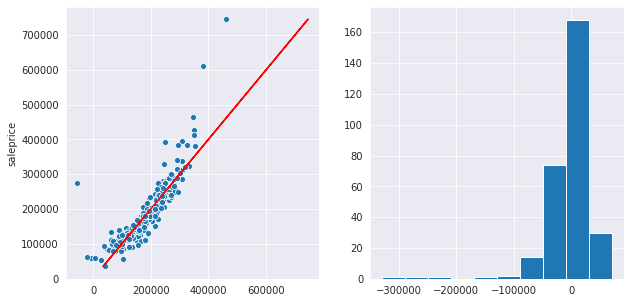

The mean of the errors is -2581.402279913376


In [1060]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.set_style('darkgrid')
sns.scatterplot(y_preds_test,y_test)
plt.plot(y_test,y_test, color='r')

plt.subplot(1,2,2)
plt.hist(y_preds_test - y_test)
plt.show()

print(f'The mean of the errors is {np.mean(y_preds_test - y_test)}')

> ### We can see that our model predicts the lower to mid-priced houses well although it seemes to have made some negative predictions on a few houses. Also, our errors have failed to meet two of the assumptions for linear regression: the error term should be zero on average and normally distributed.

# Homoscedasticity

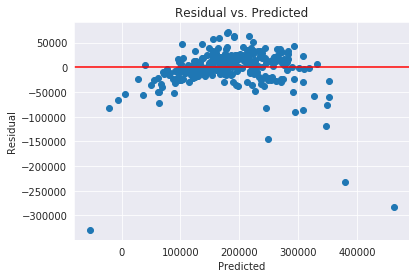

In [1061]:
plt.scatter(y_preds_test, y_preds_test - y_test)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0, color='r')
plt.title('Residual vs. Predicted')
plt.show()

# Low Multicollinearity?

In [1062]:
X.corr()

,poolqc_Fa,poolqc_Gd,grlivarea,lotarea,totalbsmtsf,garagearea,bedroomabvgr,yearbuilt,fullbath,kitchenabvgr,totrmsabvgrd,fireplaces,overallqual,overallcond,lotfrontage
poolqc_Fa,1.000000,-0.001681,0.037441,0.010762,0.013392,0.008841,0.051482,0.005805,0.029250,-0.007832,0.045183,0.050976,0.010734,-0.002508,0.015056
poolqc_Gd,-0.001681,1.000000,0.127114,0.093845,0.163159,0.055841,0.025979,0.018634,0.008371,-0.009595,0.060011,0.074189,0.040502,0.017322,0.170996
grlivarea,0.037441,0.127114,1.000000,0.263116,0.454868,0.468997,0.521270,0.199010,0.630012,0.100063,0.825489,0.461679,0.593007,-0.079686,0.368392
lotarea,0.010762,0.093845,0.263116,1.000000,0.260833,0.180403,0.119690,0.014228,0.126031,-0.017784,0.190015,0.271364,0.105806,-0.005636,0.306795
totalbsmtsf,0.013392,0.163159,0.454868,0.260833,1.000000,0.486665,0.050450,0.391452,0.323722,-0.068901,0.285573,0.339519,0.537808,-0.171098,0.363358
garagearea,0.008841,0.055841,0.468997,0.180403,0.486665,1.000000,0.065253,0.478954,0.405656,-0.064433,0.337822,0.269141,0.562022,-0.151521,0.323663
bedroomabvgr,0.051482,0.025979,0.521270,0.119690,0.050450,0.065253,1.000000,-0.070651,0.363252,0.198597,0.676620,0.107570,0.101676,0.012980,0.237023
yearbuilt,0.005805,0.018634,0.199010,0.014228,0.391452,0.478954,-0.070651,1.000000,0.468271,-0.174800,0.095589,0.147716,0.572323,-0.375983,0.117598
fullbath,0.029250,0.008371,0.630012,0.126031,0.323722,0.405656,0.363252,0.468271,1.000000,0.133115,0.554784,0.243671,0.550600,-0.194149,0.180424
kitchenabvgr,-0.007832,-0.009595,0.100063,-0.017784,-0.068901,-0.064433,0.198597,-0.174800,0.133115,1.000000,0.256045,-0.123936,-0.183882,-0.087001,-0.005805


> ### There seems to be some high correlations between 'garagearea', 'totalbsmtsf' and grlivarea' with other features that will need to be addressed in future models. 'fullbath', 'totrmsabvgrd', 'fireplaces', and 'overallqual' also have some troublesome correlations with other features.

### In order to increase the goodness of fit of our model:

1. We first log transform the dependent variable. Recall from the checkpoint 2 that the saleprice variable is not normally distributed, so log transforming may help in this regard. To this end, we apply log transformation of NumPy.
2. Second, we create another variable by summing up the basement, first, second floor and garage areas.
3. Third, we create a 'totalbath' variable summing the total of all bathroom types in the house
4. Finally, we add the interaction of the total area and the overall quality of the house.

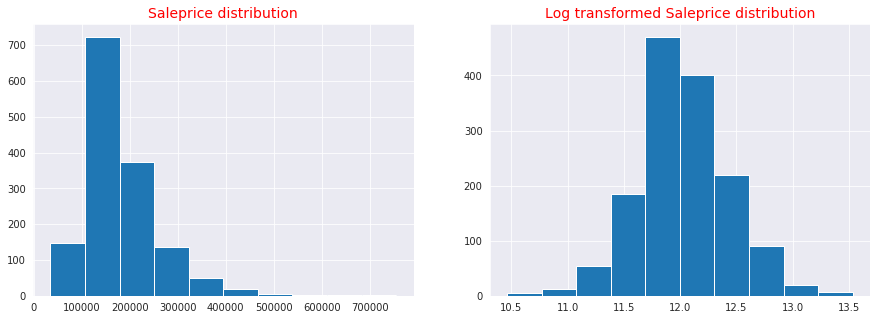

In [1063]:
# Examining the distribution of our target variable

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(houses_df_dummies.saleprice)
plt.title('Saleprice distribution', size=14, color='r')

plt.subplot(1,2,2)
plt.hist(np.log(houses_df_dummies.saleprice))
plt.title('Log transformed Saleprice distribution', size=14, color='r')
plt.show()

In [1064]:
# Engineering some interactive features

# Here, we create a total living area without use of the 'grlivarea' feature and adding 'garagearea' with other 
# area related features, including the previously problematic (correlation-wise)'totalbsmtsf'. Also, 'fullbath'
# and 'overallqual' have been combined into interative features with other variables
houses_df_dummies['totalsf'] = houses_df['totalbsmtsf'] + houses_df['firstflrsf'] + houses_df['secondflrsf'] + houses_df['garagearea']
houses_df_dummies['totalbath'] = houses_df['fullbath'] + houses_df['halfbath'] + houses_df['bsmtfullbath'] + \
                                 houses_df['bsmthalfbath']
houses_df_dummies['qc_by_sf'] = houses_df_dummies['totalsf'] * houses_df['overallqual']

# 'totrmsabvgrd', and 'fireplaces' are also removed
features = ['totalbath','qc_by_sf','lotarea','yearbuilt','overallcond']

X = houses_df_dummies[features + dummy_columns]
Y = np.log(houses_df_dummies.saleprice)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=465)

# Don't forget to add a constant for statsmodels OLS
X_train_c = sm.add_constant(X_train)

# Let's train our new model
results = sm.OLS(y_train, X_train_c).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     720.9
Date:                Mon, 03 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:40:52   Log-Likelihood:                 401.21
No. Observations:                1168   AIC:                            -786.4
Df Residuals:                    1160   BIC:                            -745.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.6797      0.445     10.525      0.000       3.807       5.552
totalbath       0.0730      0.007     10.203      0.000       0.059       0.087
qc_by_sf     2.554e-05   6.51e-07     39.212      0.000    2.43e-05    2.68e-05
lotarea      2.793e-06   4.91e-07      5.687      0.000    1.83e-06    3.76e-06
yearbuilt       0.0032      0.000     14.561      0.000       0.003       0.004
overallcond     0.0660      0.005     13.498      0.000       0.056       0.076
poolqc_Fa    2.502e-16   1.56e-17     16.028      0.000     2.2e-16    2.81e-16
poolqc_Gd      -1.5640      0.213     -7.349      0.000      -1.982      -1.146
poolqc_NoPo     0.0419      0.174      0.241      0.810      -0.299       0.383
==============================================================================
Omnibus:                      672.527   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52500.354
Skew:                          -1.802   Prob(JB):                         0.00
Kurtosis:                      35.646   Cond. No.                     7.23e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.4e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1065]:
# sklearn's OLS
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_train - y_preds_train) / y_train)) * 100))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8130831564163403
Mean absolute percentage error of the prediction is: 0.8967860146877973
-----Test set statistics-----
R-squared of the model in test set is: 0.79450054989262
Mean absolute error of the prediction is: 0.10325663877039143
Mean squared error of the prediction is: 0.03426659801226555
Root mean squared error of the prediction is: 0.1851123929191818
Mean absolute percentage error of the prediction is: 0.8649854892671796


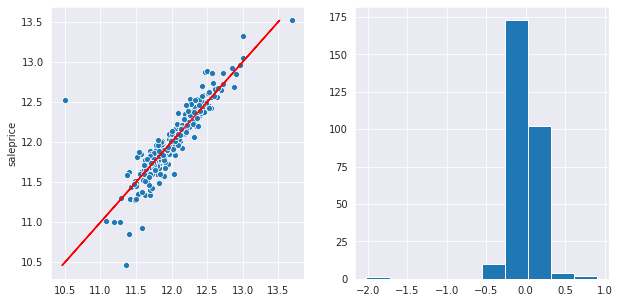

The mean of the errors is -0.003411860776416782


In [1066]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.set_style('darkgrid')
sns.scatterplot(y_preds_test,y_test)
plt.plot(y_test,y_test, color='r')

plt.subplot(1,2,2)
plt.hist(y_preds_test - y_test)
plt.show()

print(f'The mean of the errors is {np.mean(y_preds_test - y_test)}')

> ### With the changes we've made, our average errors are much closer to zero. Also, our model is predicting the higher priced houses much better when we predict the log transformations.

In [1067]:
# Checking for quadratic relationship between numerical, non-engineered variables and the target feature
squared_columns = pd.DataFrame()
for c in houses_df_dummies[features].columns:
    houses_df_dummies[str(c) + '**2'] = houses_df_dummies[c]**2
    squared_columns = pd.concat([squared_columns, houses_df_dummies[str(c) + '**2']], axis=1)

In [1068]:
squared_columns.head()

,totalbath**2,qc_by_sf**2,lotarea**2,yearbuilt**2,overallcond**2
0,16,475152804,71402500,4012009,25
1,9,320553216,92160000,3904576,64
2,16,538147204,126562500,4004001,25
3,4,475458025,91202500,3667225,25
4,16,1117698624,203347600,4000000,25


In [1069]:
pd.concat([houses_df_dummies, squared_columns])
squared_columns.columns

Index(['totalbath**2', 'qc_by_sf**2', 'lotarea**2', 'yearbuilt**2',
       'overallcond**2'],
      dtype='object')

In [1070]:
# Using the features of our most successful OLS model so far (adjusted R-squared of 0.738) with added
# 'mszoning' dummies
features = features + list(squared_columns)

X = houses_df_dummies[features + dummy_columns]
Y = np.log(houses_df_dummies.saleprice)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

# Don't forget to add a constant
X_train_c = sm.add_constant(X_train)

# Let's train our new model
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     793.3
Date:                Mon, 03 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:40:53   Log-Likelihood:                 674.90
No. Observations:                1168   AIC:                            -1326.
Df Residuals:                    1156   BIC:                            -1265.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
totalbath          0.0548      0.021      2.549      0.011       0.013       0.097
qc_by_sf        4.811e-05   1.09e-06     43.953      0.000     4.6e-05    5.03e-05
lotarea         8.822e-06   9.46e-07      9.328      0.000    6.97e-06    1.07e-05
yearbuilt          0.0081      0.000     37.238      0.000       0.008       0.009
overallcond        0.1689      0.026      6.594      0.000       0.119       0.219
totalbath**2      -0.0005      0.004     -0.121      0.903      -0.008       0.007
qc_by_sf**2    -3.652e-10   1.51e-11    -24.218      0.000   -3.95e-10   -3.36e-10
lotarea**2     -3.705e-11   5.48e-12     -6.765      0.000   -4.78e-11   -2.63e-11
yearbuilt**2   -1.488e-06   9.48e-08    -15.700      0.000   -1.67e-06    -1.3e-06
overallcond**2    -0.0093      0.002     -4.339      0.000      -0.014      -0.005
poolqc_Fa       1.002e-16   4.86e-17      2.063      0.039    4.89e-18    1.96e-16
poolqc_Gd          0.3327      0.185      1.794      0.073      -0.031       0.697
poolqc_NoPo        0.1794      0.138      1.299      0.194      -0.092       0.450
==============================================================================
Omnibus:                      316.681   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1880.456
Skew:                          -1.114   Prob(JB):                         0.00
Kurtosis:                       8.803   Cond. No.                     5.67e+26
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.19e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1071]:
# sklearn's OLS
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_train - y_preds_train) / y_train)) * 100))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8833895102464042
Mean absolute percentage error of the prediction is: 0.8110990310131266
-----Test set statistics-----
R-squared of the model in test set is: 0.8715157633565437
Mean absolute error of the prediction is: 0.09839082990057173
Mean squared error of the prediction is: 0.02142447430235731
Root mean squared error of the prediction is: 0.14637101592308946
Mean absolute percentage error of the prediction is: 0.8239519651426578


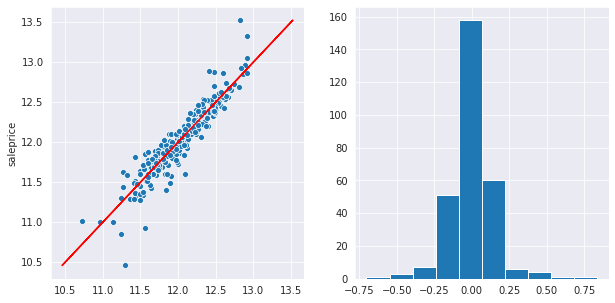

The mean of the errors is -0.0004890163346763737


In [1072]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.set_style('darkgrid')
sns.scatterplot(y_preds_test,y_test)
plt.plot(y_test,y_test, color='r')

plt.subplot(1,2,2)
plt.hist(y_preds_test - y_test)
plt.show()

print(f'The mean of the errors is {np.mean(y_preds_test - y_test)}')

> ### We now see significant improvement in our residual/error normality as well as our average error getting even closer to zero.

In [1073]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

# Fitting a ridge regression model with cross valivation. Alpha is the regularization parameter 
# (usually called lambda). As alpha gets larger, parameter shrinkage grows more pronounced.
ridge_cv = RidgeCV(alphas=alphas, cv=10)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_train - y_preds_train) / y_train)) * 100))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.1
R-squared of the model in training set is: 0.8833778990880176
Mean absolute percentage error of the prediction is: 0.8110680408675472
-----Test set statistics-----
R-squared of the model in test set is: 0.8729676476973333
Mean absolute error of the prediction is: 0.09823464993474554
Mean squared error of the prediction is: 0.021182375663941752
Root mean squared error of the prediction is: 0.14554166298329063
Mean absolute percentage error of the prediction is: 0.8227331880000653


In [1074]:
# Fitting a LASSO regression model with cross valivation.
lasso_cv = LassoCV(alphas=alphas, cv=10)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_train - y_preds_train) / y_train)) * 100))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-05
R-squared of the model in training set is: 0.8832313740715093
Mean absolute percentage error of the prediction is: 0.8117553475369385
-----Test set statistics-----
R-squared of the model in test set is: 0.8723469595173935
Mean absolute error of the prediction is: 0.09838740385142956
Mean squared error of the prediction is: 0.021285874103192295
Root mean squared error of the prediction is: 0.14589679264189565
Mean absolute percentage error of the prediction is: 0.8238967882184324


In [1075]:
# Fitting an ElasticNet regression model with cross valivation.
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=10)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_train - y_preds_train) / y_train)) * 100))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.8831219491540315
Mean absolute percentage error of the prediction is: 0.8119679906008074
-----Test set statistics-----
R-squared of the model in test set is: 0.8753949805663103
Mean absolute error of the prediction is: 0.09794680302081601
Mean squared error of the prediction is: 0.02077762304966598
Root mean squared error of the prediction is: 0.14414445202527215
Mean absolute percentage error of the prediction is: 0.8204497608858904


> ### Our ElasticNet regression model performed slightly better than the rest when considering both training and testing sets.

# Introducing GDP data

In [1076]:
# Gives us a list of dataframes
gdp = pd.read_html('https://www.thebalance.com/us-gdp-by-year-3305543', header=0)
# Indexing the first (and only) dataframe in the list
gdp = gdp[0]
gdp = gdp.rename(columns={'GDP Growth Rate':'GDP Growth Rate %'})
gdp.columns = gdp.columns.str.strip().str.replace(' ','_').str.replace('(','').str.replace(')','').str.lower()
gdp.head(3)

,year,nominal_gdp_trillions,real_gdp_trillions,gdp_growth_rate_%,events_affecting_gdp
0,1929,$0.105,$1.109,NaN,Depression began
1,1930,$0.092,$1.015,-8.5%,Smoot-Hawley
2,1931,$0.077,$0.950,-6.4%,Dust Bowl


In [1077]:
gdp = gdp.set_index('year')

In [1078]:
gdp.head(3)

,nominal_gdp_trillions,real_gdp_trillions,gdp_growth_rate_%,events_affecting_gdp
year,,,,
1929,$0.105,$1.109,NaN,Depression began
1930,$0.092,$1.015,-8.5%,Smoot-Hawley
1931,$0.077,$0.950,-6.4%,Dust Bowl


In [1079]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 1929 to 2019
Data columns (total 4 columns):
nominal_gdp_trillions    91 non-null object
real_gdp_trillions       91 non-null object
gdp_growth_rate_%        90 non-null object
events_affecting_gdp     75 non-null object
dtypes: object(4)
memory usage: 3.6+ KB


In [1080]:
#####    Can only run this cell once   #####

gdp['real_gdp_trillions'] = gdp['real_gdp_trillions'].str.strip('$').str.replace(',','.').astype('float')
gdp['nominal_gdp_trillions'] = gdp['nominal_gdp_trillions'].str.strip('$').str.replace(',','.').astype('float')
gdp['gdp_growth_rate_%'] = gdp['gdp_growth_rate_%'].str.strip('%').astype('float')

gdp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 1929 to 2019
Data columns (total 4 columns):
nominal_gdp_trillions    91 non-null float64
real_gdp_trillions       91 non-null float64
gdp_growth_rate_%        90 non-null float64
events_affecting_gdp     75 non-null object
dtypes: float64(3), object(1)
memory usage: 3.6+ KB


In [1081]:
gdp.describe(include='all')

,nominal_gdp_trillions,real_gdp_trillions,gdp_growth_rate_%,events_affecting_gdp
count,91.000000,91.000000,90.000000,75
unique,NaN,NaN,NaN,65
top,NaN,NaN,NaN,Recession
freq,NaN,NaN,NaN,6
mean,4.995055,7.240066,3.325556,NaN
std,6.159848,5.483496,4.846256,NaN
min,0.057000,0.817000,-12.900000,NaN
25%,0.357000,2.524500,1.725000,NaN
50%,1.545000,5.657000,3.250000,NaN
75%,8.325500,11.276500,5.050000,NaN


In [1082]:
houses_df_dummies['real_gdp'] = ''

In [1083]:
for idx, year in enumerate(houses_df_dummies.yrsold):
    houses_df_dummies['real_gdp'][idx] = gdp.real_gdp_trillions[year]

In [1084]:
houses_df_dummies.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolqc_NoPo,totalsf,totalbath,qc_by_sf,totalbath**2,qc_by_sf**2,lotarea**2,yearbuilt**2,overallcond**2,real_gdp
0,1,60,RL,65.0,8450,Pave,NoAl,Reg,Lvl,AllPub,...,1,3114,4,21798,16,475152804,71402500,4012009,25,15.605
1,2,20,RL,80.0,9600,Pave,NoAl,Reg,Lvl,AllPub,...,1,2984,3,17904,9,320553216,92160000,3904576,64,15.626
2,3,60,RL,68.0,11250,Pave,NoAl,IR1,Lvl,AllPub,...,1,3314,4,23198,16,538147204,126562500,4004001,25,15.605
3,4,70,RL,60.0,9550,Pave,NoAl,IR1,Lvl,AllPub,...,1,3115,2,21805,4,475458025,91202500,3667225,25,15.338
4,5,60,RL,84.0,14260,Pave,NoAl,IR1,Lvl,AllPub,...,1,4179,4,33432,16,1117698624,203347600,4000000,25,15.605


In [1085]:
features = features + ['real_gdp']

X = houses_df_dummies[features + dummy_columns]
Y = houses_df_dummies.saleprice

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

# Don't forget to add a constant
X_train_c = sm.add_constant(X_train)

# Let's train our new model
results = sm.OLS(y_train, X_train_c.astype(float)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     465.1
Date:                Mon, 03 Feb 2020   Prob (F-statistic):               0.00
Time:                        22:42:51   Log-Likelihood:                -13756.
No. Observations:                1168   AIC:                         2.754e+04
Df Residuals:                    1154   BIC:                         2.761e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.885e+06   4.08e+06      0.707      0.480   -5.12e+06    1.09e+07
totalbath      -1.982e+04   4998.312     -3.965      0.000   -2.96e+04      -1e+04
qc_by_sf           8.8705      0.270     32.811      0.000       8.340       9.401
lotarea            1.3509      0.225      6.010      0.000       0.910       1.792
yearbuilt      -3297.0574   4173.189     -0.790      0.430   -1.15e+04    4890.830
overallcond     1.078e+04   5968.540      1.806      0.071    -928.797    2.25e+04
totalbath**2    5092.7596    925.432      5.503      0.000    3277.042    6908.477
qc_by_sf**2    -5.007e-05   3.54e-06    -14.132      0.000    -5.7e-05   -4.31e-05
lotarea**2      -4.99e-06   1.29e-06     -3.874      0.000   -7.52e-06   -2.46e-06
yearbuilt**2       0.9195      1.067      0.862      0.389      -1.173       3.012
overallcond**2  -300.8056    500.637     -0.601      0.548   -1283.067     681.456
real_gdp       -3279.3050   5320.136     -0.616      0.538   -1.37e+04    7158.918
poolqc_Fa       1.038e-11   3.51e-12      2.953      0.003    3.48e-12    1.73e-11
poolqc_Gd      -5.601e+04   4.31e+04     -1.298      0.195   -1.41e+05    2.86e+04
poolqc_NoPo     7.393e+04   3.21e+04      2.302      0.021    1.09e+04    1.37e+05
==============================================================================
Omnibus:                      313.652   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16513.842
Skew:                           0.347   Prob(JB):                         0.00
Kurtosis:                      21.408   Cond. No.                     2.74e+27
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.1e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1086]:
# Using, and comparing sklearn's regression models, First, OLS...
# Undoing the sm.add_constant() used with stats model's OLS algorithm
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_train - y_preds_train) / y_train)) * 100))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8397271672424623
Mean absolute percentage error of the prediction is: 12.178313893188841
-----Test set statistics-----
R-squared of the model in test set is: 0.7799240944339739
Mean absolute error of the prediction is: 22439.842729278815
Mean squared error of the prediction is: 1477524504.9044056
Root mean squared error of the prediction is: 38438.5809429069
Mean absolute percentage error of the prediction is: 13.328495868009332


### With the addition of GDP data, the regression performed worse than our previous models. 